In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# required for visualizing plots directly in Jupyter Notebook
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


First let's read the training data and explore it

In [2]:
# reading the training dataset
train = pd.read_csv('input/sales_train_v2.csv')

# explore the train dataset structure
train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [3]:
train.tail()

date  date_block_num  shop_id  item_id  item_price  \
2935844  10.10.2015              33       25     7409       299.0   
2935845  09.10.2015              33       25     7460       299.0   
2935846  14.10.2015              33       25     7459       349.0   
2935847  22.10.2015              33       25     7440       299.0   
2935848  03.10.2015              33       25     7460       299.0   

         item_cnt_day  
2935844           1.0  
2935845           1.0  
2935846           1.0  
2935847           1.0  
2935848           1.0

We see that the column **'date'** can be converted to a datetime index for our dataframe. However I do not have to do that as my data already has a column **'date_block_num'** which shows the month in which the given sell occured. I will keep the column as it will not harm having it but I do not plan to use it for my prediction.

An interesting observation is that I have a negavite amount in my **'item_cnt_day'** column. I assume that this was actually delivered to the shop. If I was to aggregate the column **'item_cnt_day'** based on **['date_block_num', 'shop_id', 'item_id']** these negative values will actually decrease my total sales which will lead me into a wrong conclusions. Thus I will filter my data only for the positive values of **'item_cnt_day'**.

The first thing which I will explore it is to find the total number of sales per shop per month. This will give me information about the general trend of sales and also help me identify if all the shops are still open.

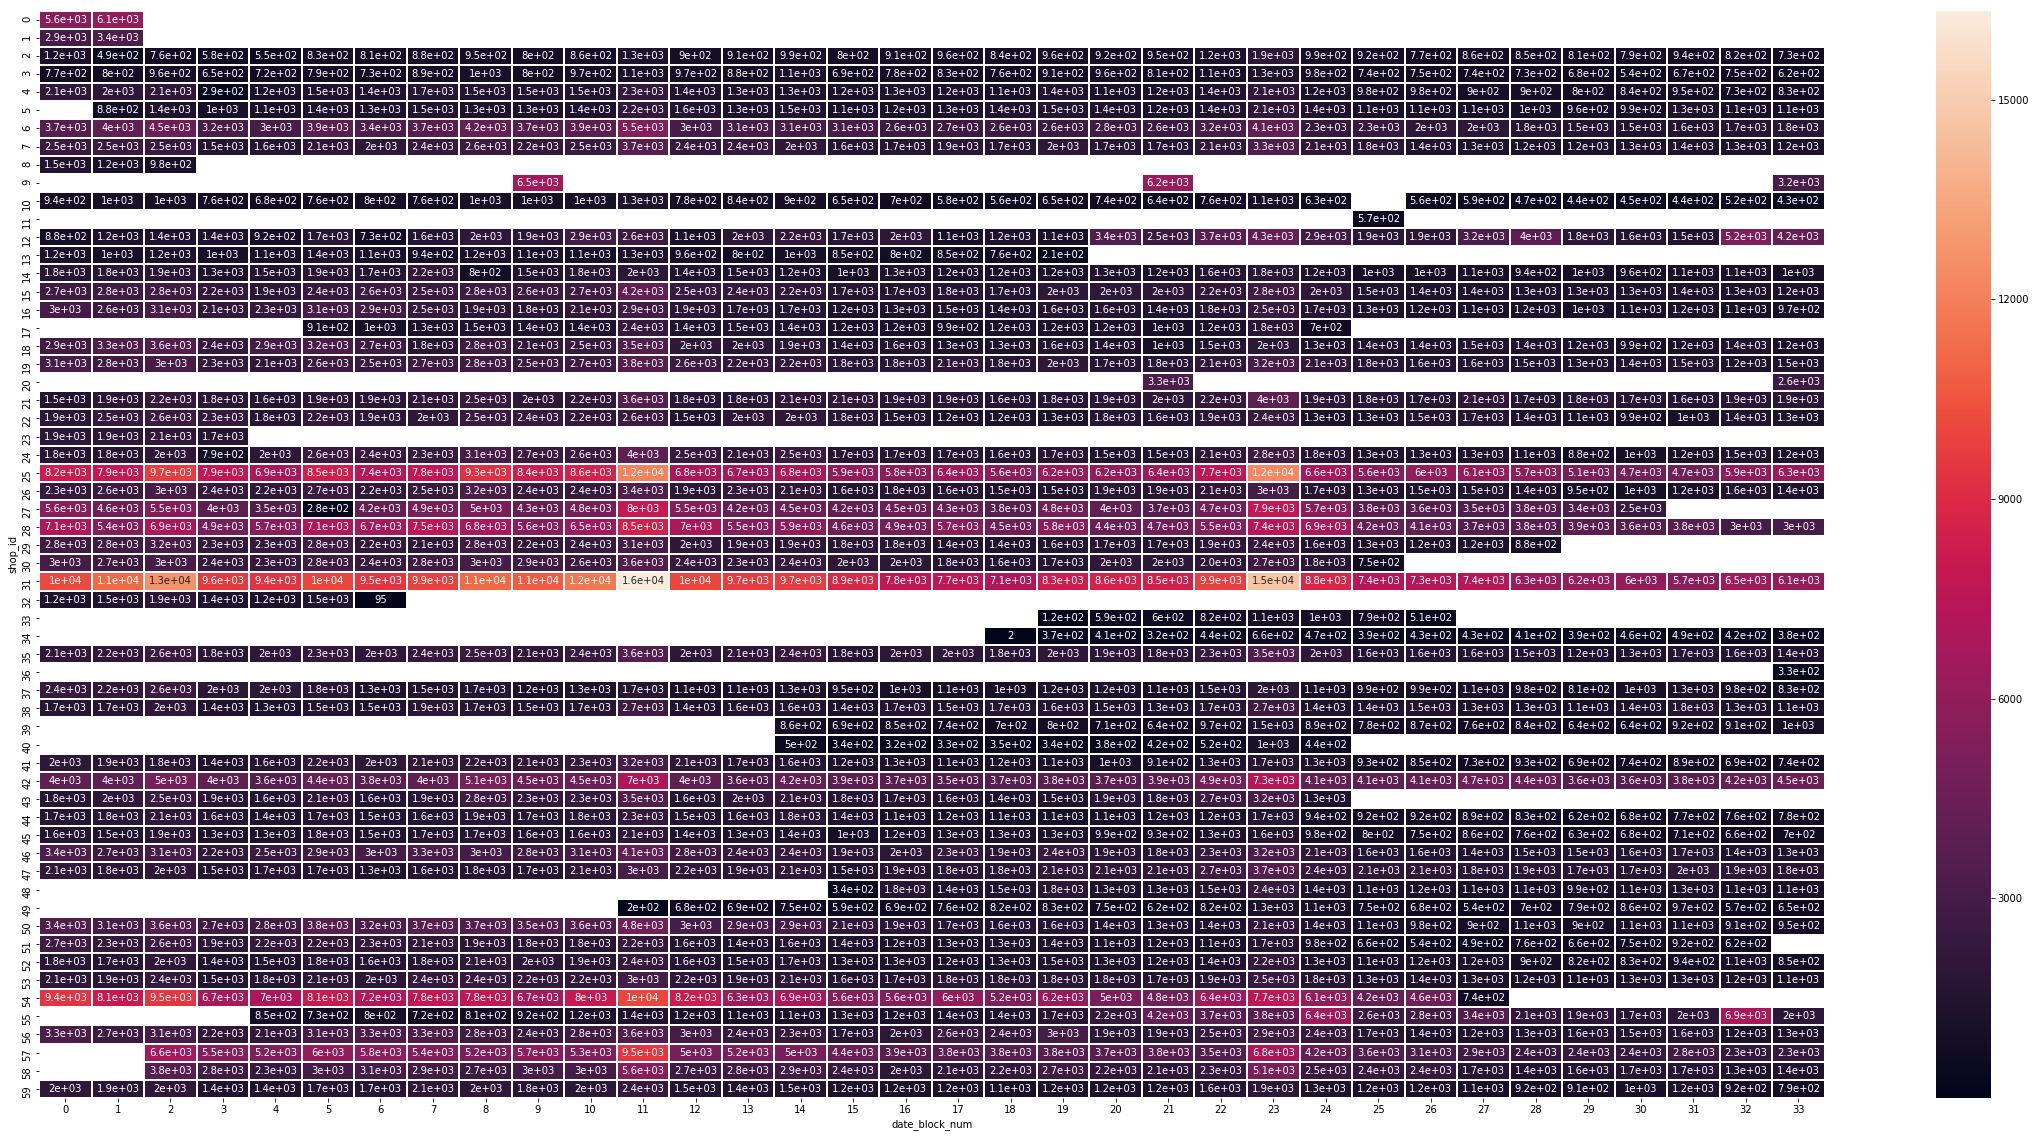

In [4]:
# filtering the train dataset only on the SALES data
filter_1 = train['item_cnt_day'] > 0

# applying the filter and creating new dataframe
filtered_1 = train[filter_1]

# setting a plot size
plt.rcParams['figure.figsize'] = (40.0, 20.0)

# 2D plot for total sales/month per shops
sns.heatmap(filtered_1.pivot_table(values='item_cnt_day', 
                                   index='shop_id', 
                                   columns='date_block_num', 
                                   aggfunc='sum', 
                                   dropna=True
                                  ), 
            linewidths=1, 
            annot=True, 
            annot_kws={"size": 10}
           )

From the plot I can observe that several shops appear to be closed in the last month **'date_block_num' == 33**. This might be a long shot but I would rather predict **0** sales regardless of the **item_id** for these shops in my test dataset than to apply any sort of learning algorithm on them. Thus I will reduce my sales dataset only to these shops which *(in my opininon)* are still open.

In [5]:
# list of shops which were operational during the last month 'date_block_num' == 33
filter_2 = filtered_1[(filtered_1['date_block_num'] == 33)]['shop_id'].unique()

# subset of the sales dataset based on filter_1
filtered_2 = filtered_1[filtered_1['shop_id'].isin(filter_2)]

Let's explore the total number of sales again, this time on the filtered data

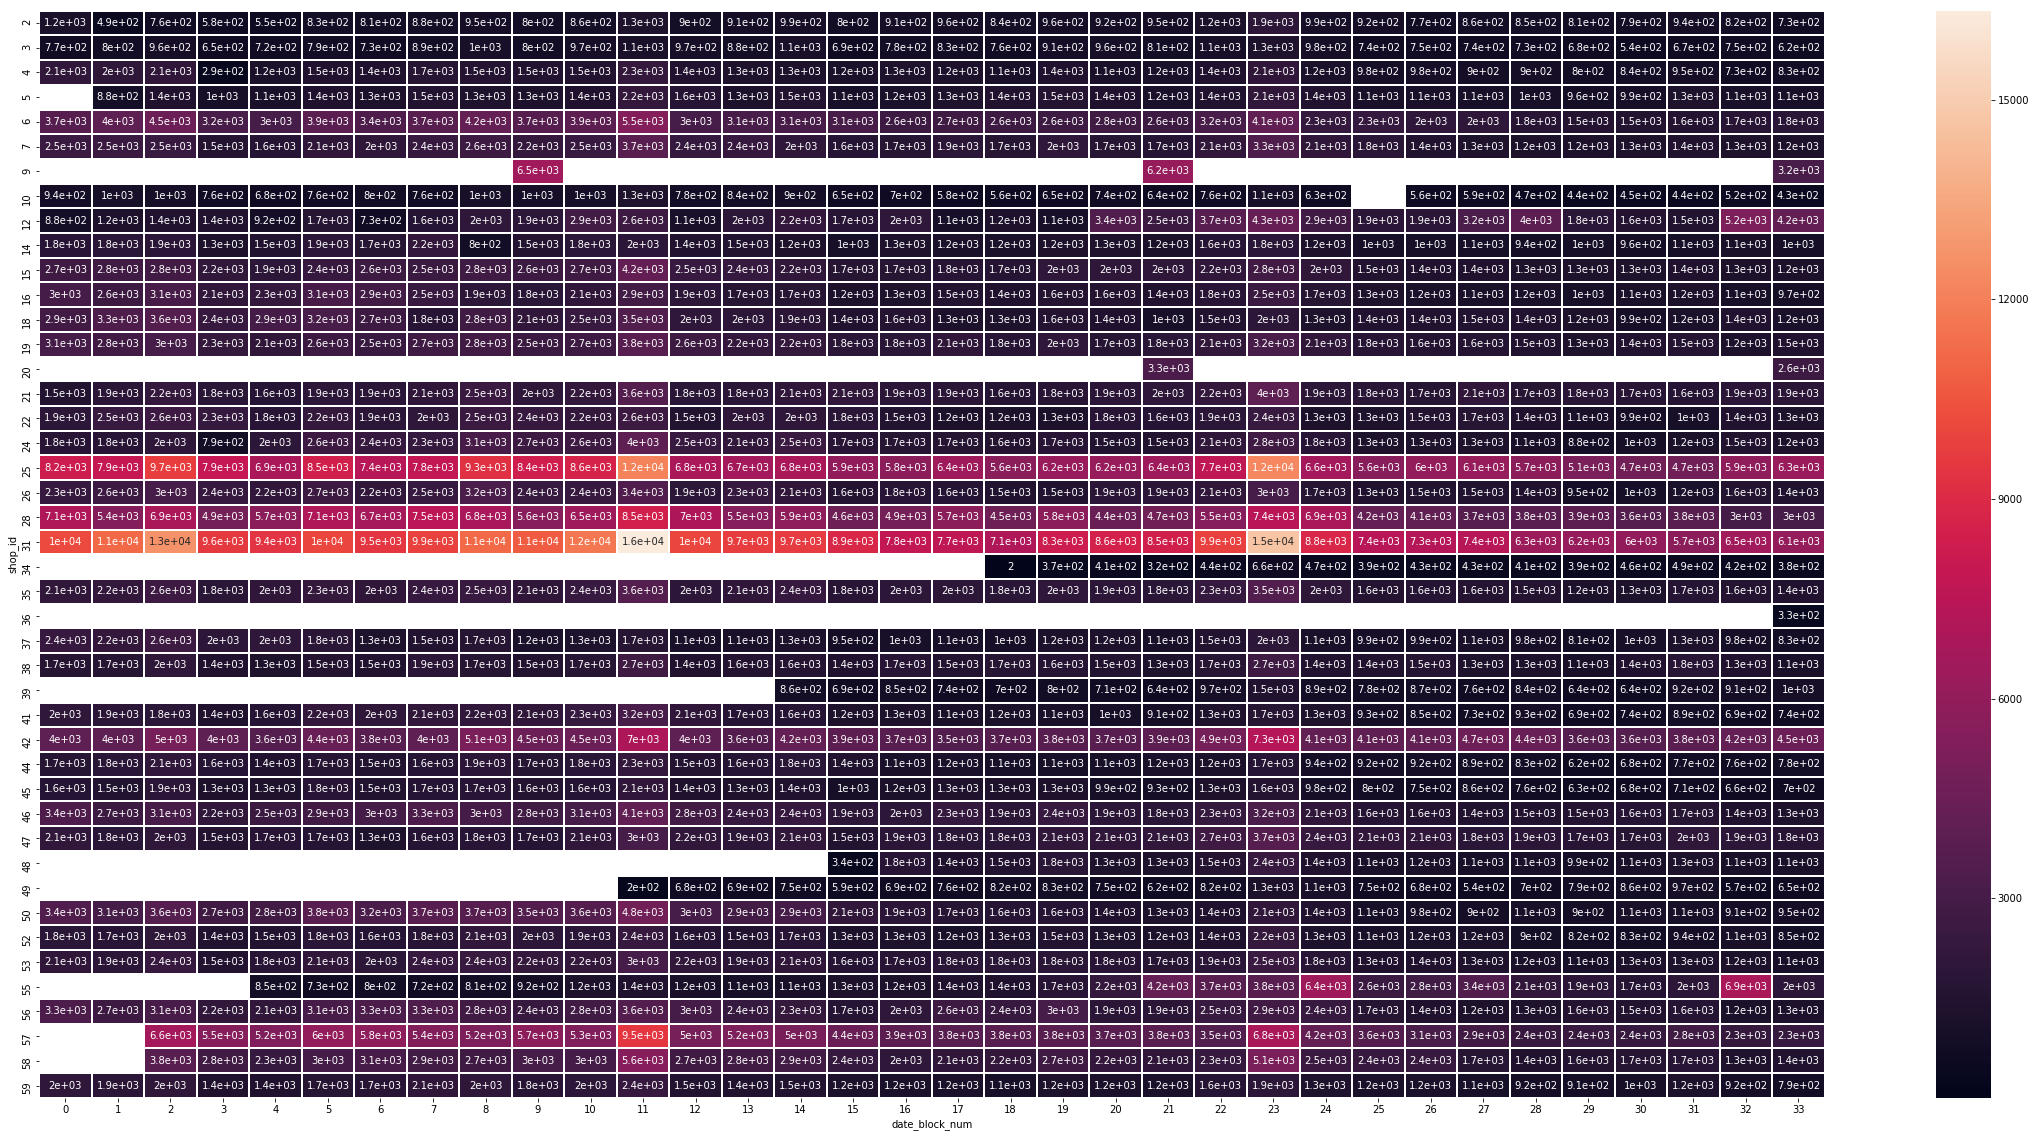

In [6]:
# setting a plot size
plt.rcParams['figure.figsize'] = (40.0, 20.0)

# 2D plot for total sales/month per shops
sns.heatmap(filtered_2.pivot_table(values='item_cnt_day', 
                                   index='shop_id', 
                                   columns='date_block_num', 
                                   aggfunc='sum', 
                                   dropna=True
                                  ), 
            linewidths=1, 
            annot=True, 
            annot_kws={"size": 10}
           )

The plot already looks good in term of patter recognition however I will make it even more clear

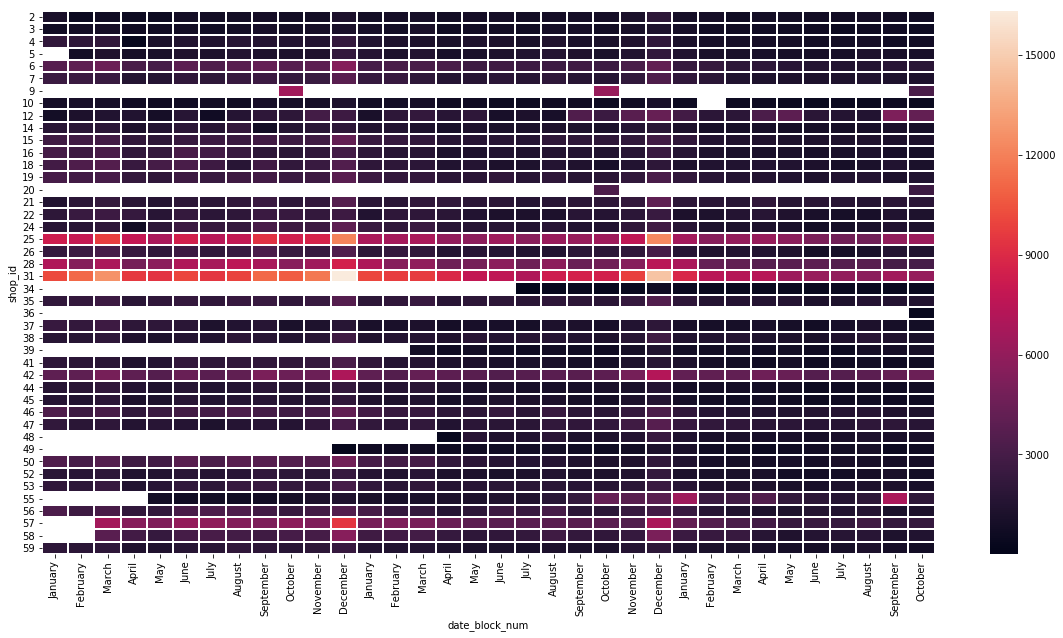

In [7]:
# defining a list with the month names for a period of 99 year (99 is more or less an arbitrary number)
months = ['January','February','March','April','May','June','July','August','September','October','November','December']*99

# setting a plot size
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# 2D plot for total sales/month per shops
sns.heatmap(filtered_2.pivot_table(values='item_cnt_day', 
                                   index='shop_id', 
                                   columns='date_block_num', 
                                   aggfunc='sum', 
                                   dropna=True
                                  ), 
            linewidths=1, 
            xticklabels=months[0:34]
           )

From this plot we can observe that there are 3 shops **[9,20,36]** which are open only in October. I believe there is a reason for this e.g. high demand due to public holidays in Russia or whatsoever but I am not really interested in the exact details behind this. I will simply filter my dataset once again and remove those shops. As you may have guessed so far I will predict **0** for those shops as my objective is to estimate the sales for **November 2015**.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5]),
 <a list of 41 Text yticklabel objects>)

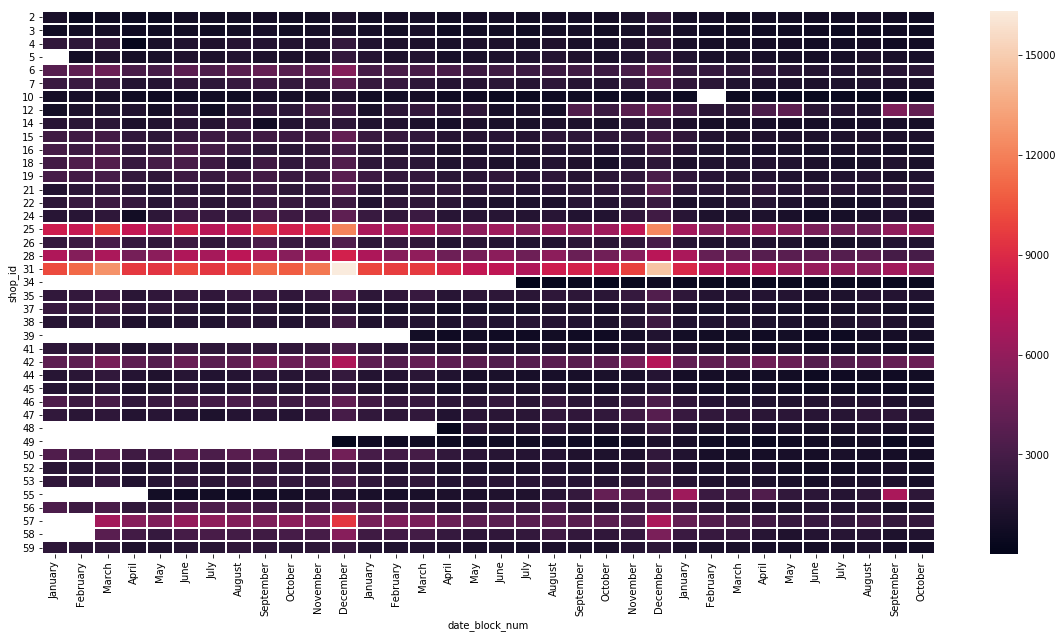

In [8]:
# list of shops which were operational in 'December'
filter_3 = filtered_2[(filtered_2['date_block_num'] == 23)]['shop_id'].unique()

# subset of the sales dataset based on filter_1
filtered_3 = filtered_2[filtered_2['shop_id'].isin(filter_3)]

# defining a list with the month names for a period of 99 year (99 is more or less an arbitrary number)
months = ['January','February','March','April','May','June','July','August','September','October','November','December']*99

# setting a plot size
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# 2D plot for total sales/month per shops
sns.heatmap(filtered_3.pivot_table(values='item_cnt_day', 
                                   index='shop_id', 
                                   columns='date_block_num', 
                                   aggfunc='sum', 
                                   dropna=True
                                  ), 
            linewidths=1, 
            xticklabels=months[0:34]
           )

# rotating the shop_id labels on the plot
plt.yticks(rotation='horizontal')

Now I have (what I believe to be) all the shops which need an actual prediction. I will start by predicting the total number of sales for each shop and later I will break (distribute) this number amoung the different **item_id**'s.

In [9]:
# assigning the pivot table into a variable
filtered_3_pivoted = filtered_3.pivot_table(values='item_cnt_day', 
                                   index='shop_id', 
                                   columns='date_block_num', 
                                   aggfunc='sum', 
                                   dropna=True
                                  )

# converting the pivot table into a dataframe
filtered_3_records = pd.DataFrame(filtered_3_pivoted.to_records())

# transposing the dataframe
filtered_3_records = filtered_3_records.transpose()

# assiginig the correct column names
filtered_3_records.columns = filtered_3_records.loc['shop_id'].astype('str')

# ---------------- converting 2.0 into 2 and etc.
new_names = []

for name in filtered_3_records.columns:
    new_names.append(name.split('.')[0])

filtered_3_records.columns = new_names

# removing the 'shop_id' row
filtered_3_records.drop('shop_id', axis=0, inplace=True)

# replacing the NaN values with 0.0
filtered_3_records.fillna(value=0.0, inplace=True)

# converting the index to dtype='int64'
filtered_3_records.index = filtered_3_records.index.astype('int64')

# exploring the dataframe
filtered_3_records.head()

2      3       4       5       6       7      10      12      14  \
0  1151.0  767.0  2117.0     0.0  3699.0  2498.0   935.0   881.0  1779.0   
1   489.0  801.0  2036.0   879.0  4017.0  2516.0  1026.0  1222.0  1799.0   
2   756.0  959.0  2069.0  1357.0  4528.0  2464.0  1017.0  1431.0  1896.0   
3   585.0  648.0   287.0  1008.0  3174.0  1541.0   756.0  1407.0  1251.0   
4   553.0  718.0  1212.0  1111.0  3027.0  1648.0   683.0   922.0  1495.0   

       15   ...     48   49      50      52      53     55      56      57  \
0  2730.0   ...    0.0  0.0  3414.0  1819.0  2071.0    0.0  3262.0     0.0   
1  2756.0   ...    0.0  0.0  3057.0  1742.0  1917.0    0.0  2664.0     0.0   
2  2840.0   ...    0.0  0.0  3618.0  2035.0  2371.0    0.0  3110.0  6596.0   
3  2169.0   ...    0.0  0.0  2745.0  1447.0  1517.0    0.0  2156.0  5509.0   
4  1933.0   ...    0.0  0.0  2840.0  1487.0  1774.0  852.0  2147.0  5245.0   

       58      59  
0     0.0  2026.0  
1     0.0  1906.0  
2  3781.0  2032.0  
3  2841.0  1390.0  
4  2313.0  1378.0  

[5 rows x 41 columns]

What we have now is a dataframe where each row represents the **'date_block_num'** , each column the **shop_id** and the values inside are the total number of sales for that combination.

In order for you to get the sense of timeseries data I need to produce one more plot

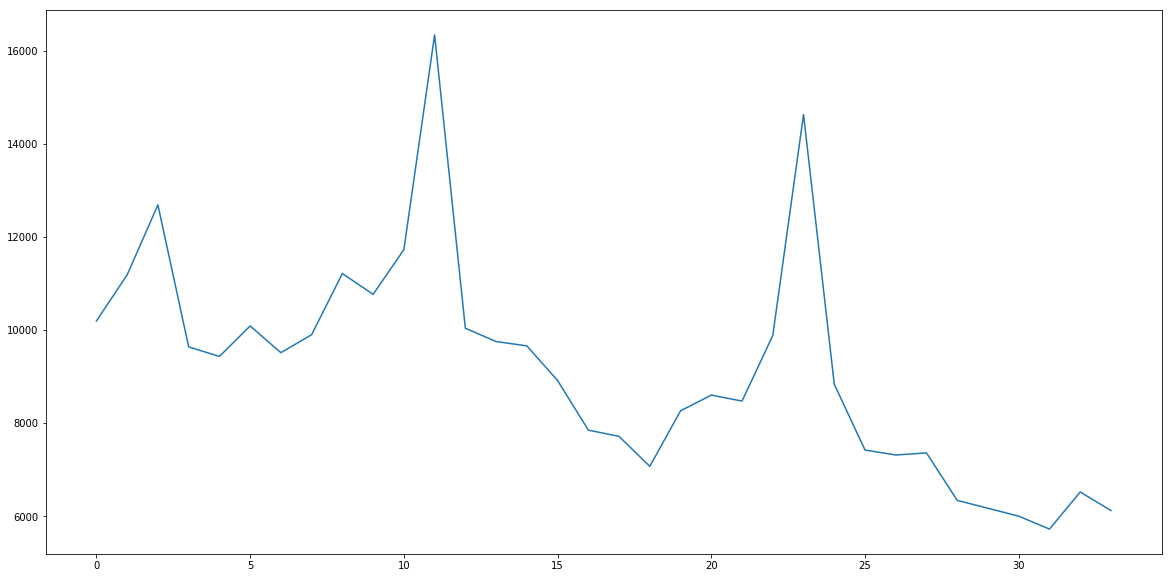

In [10]:
# showing time-history of total sales for shop 31
filtered_3_records['31'].plot()

If we were to explore the ETS (error,trend,seasonality) of this data we can easily look at its seasonal decomposition provided by the statsmodels package.

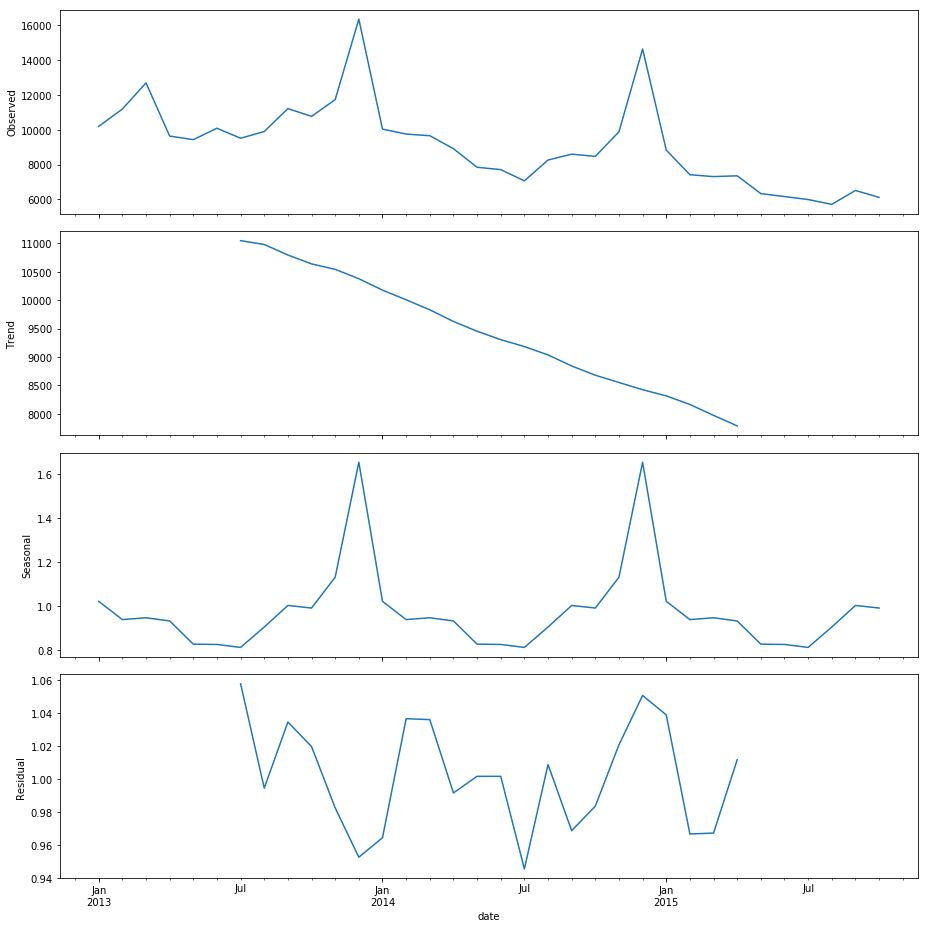

In [17]:
plt.rcParams['figure.figsize'] = (13, 13)

filtered_3_records['date'] = pd.date_range(start='2013-01-01', end='2015-11-01', freq='M')

filtered_3_records = filtered_3_records.set_index('date')

decomposed = sm.tsa.seasonal_decompose(filtered_3_records['31'], freq=12, model='multiplicative').plot()

Using the data from the plot above I could predict the future sales by extrapolating the trend component and multiplying it with the corresponding seasonal value. However the error component (residuals) I cannot estimate as they tend to follow a random pattern. Just for reference here is a histogram of the residuals:

(array([7., 8., 7.]),
 array([0.94551897, 0.98293639, 1.02035381, 1.05777123]),
 <a list of 3 Patch objects>)

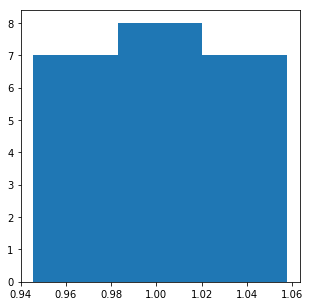

In [35]:
residuals = sm.tsa.seasonal_decompose(filtered_3_records['31'], freq=12, model='multiplicative').resid

plt.rcParams['figure.figsize'] = (5, 5)

plt.hist(residuals.dropna(), bins=3)

For forecasting I will use the fbprophet package provided by Facebook. 

In [38]:
from fbprophet import Prophet 

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


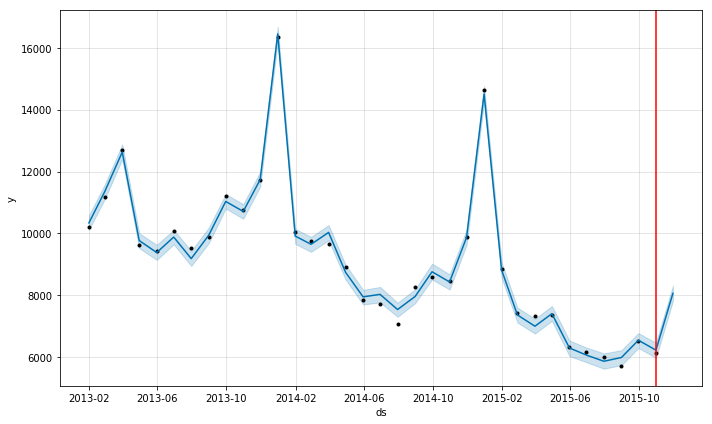

In [62]:
df = pd.DataFrame()

df['ds'] = filtered_3_records['31'].index
df['y'] = filtered_3_records['31'].values

m = Prophet().fit(df)
future = m.make_future_dataframe(periods=1, freq='M')
fcst = m.predict(future)
m.plot(fcst)
plt.axvline(x='2015-10-31', color='red')

In [68]:
fcst.head()

ds         trend   trend_lower   trend_upper    yhat_lower  \
0 2013-01-31  11909.282105  11909.282105  11909.282105  10110.798220   
1 2013-02-28  11849.256752  11849.256752  11849.256752  11107.275772   
2 2013-03-31  11782.800112  11782.800112  11782.800112  12398.574912   
3 2013-04-30  11718.487234  11718.487234  11718.487234   9519.620809   
4 2013-05-31  11652.030593  11652.030593  11652.030593   9139.290419   

     yhat_upper     seasonal  seasonal_lower  seasonal_upper  seasonalities  \
0  10580.864082 -1572.631396    -1572.631396    -1572.631396   -1572.631396   
1  11580.041543  -501.019393     -501.019393     -501.019393    -501.019393   
2  12874.900727   846.384524      846.384524      846.384524     846.384524   
3  10002.761369 -1953.686129    -1953.686129    -1953.686129   -1953.686129   
4   9627.405560 -2274.881420    -2274.881420    -2274.881420   -2274.881420   

   seasonalities_lower  seasonalities_upper       yearly  yearly_lower  \
0         -1572.631396         -1572.631396 -1572.631396  -1572.631396   
1          -501.019393          -501.019393  -501.019393   -501.019393   
2           846.384524           846.384524   846.384524    846.384524   
3         -1953.686129         -1953.686129 -1953.686129  -1953.686129   
4         -2274.881420         -2274.881420 -2274.881420  -2274.881420   

   yearly_upper          yhat  
0  -1572.631396  10336.650709  
1   -501.019393  11348.237359  
2    846.384524  12629.184636  
3  -1953.686129   9764.801105  
4  -2274.881420   9377.149174

In [55]:
fcst[['yhat_lower','yhat','yhat_upper']].loc[32:34]

yhat_lower         yhat   yhat_upper
32  6285.822100  6539.315792  6787.185461
33  5980.510221  6218.573084  6450.421883
34  7815.024013  8056.005935  8311.027989

The next thing I will do is to create a wrapper function which will return the prediction for a given store

In [85]:
def prediction(series):
    
    # create an empty dataframe
    df = pd.DataFrame()

    # assign columns
    df['ds'] = series.index
    df['y'] = series.values
    
    # make the actual prediction for the next month
    m = Prophet(weekly_seasonality=False, daily_seasonality=False).fit(df)
    future = m.make_future_dataframe(periods=1, freq='M')
    fcst = m.predict(future)
    
    # return the predicted value for the last month
    return fcst['yhat'].loc[34]

In [86]:
# initializing an empty dictionary to store the predicted values
predicted_sales = {}

for column in filtered_3_records.columns:
    
    # extracting a single column of the dataframe into a series
    # passing the series to our wrapper function
    predicted_value = prediction(filtered_3_records[column])
    
    # storing the predicted value into a dictionary
    predicted_sales[column] = predicted_value

C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Once I have the dictionary filled in I will convert it to a dataframe which I will later add to my existing dataframe.

In [131]:
df = pd.DataFrame.from_dict(predicted_sales, orient='index')
df = df.transpose()

# adding a new row to our dataframe
filtered_3_records = filtered_3_records.append(df, ignore_index=True)

# checking the last 5 rows of the dataframe
filtered_3_records.tail()

2           3           4            5            6           7  \
30   789.000000  542.000000  844.000000   994.000000  1487.000000  1327.00000   
31   943.000000  668.000000  948.000000  1297.000000  1576.000000  1411.00000   
32   825.000000  749.000000  734.000000  1098.000000  1728.000000  1292.00000   
33   727.000000  616.000000  831.000000  1054.000000  1803.000000  1216.00000   
34  1119.112365  866.636855  993.211478  1425.432867  2240.108025  1816.08337   

            10           12           14           15     ...       \
30  449.000000  1561.000000   957.000000  1318.000000     ...        
31  442.000000  1477.000000  1063.000000  1361.000000     ...        
32  519.000000  5229.000000  1097.000000  1269.000000     ...        
33  428.000000  4185.000000  1007.000000  1248.000000     ...        
34  571.717218  4405.179969  1307.472867  1684.670847     ...        

            48          49           50           52           53  \
30  1106.00000   856.00000  1128.000000   829.000000  1261.000000   
31  1313.00000   969.00000  1081.000000   938.000000  1321.000000   
32  1109.00000   569.00000   906.000000  1091.000000  1231.000000   
33  1119.00000   649.00000   950.000000   852.000000  1065.000000   
34  1564.48354  1024.11749   670.613916  1094.187618  1486.283846   

             55          56           57           58           59  
30  1658.000000  1493.00000  2357.000000  1691.000000   998.000000  
31  1976.000000  1605.00000  2788.000000  1743.000000  1216.000000  
32  6867.000000  1198.00000  2270.000000  1323.000000   915.000000  
33  1972.000000  1267.00000  2319.000000  1448.000000   792.000000  
34  4578.470769  1612.86704  3102.968199  2233.180297  1246.181632  

[5 rows x 41 columns]

Now I have the total sales for November I just need to decompose the sales amoung the different **'item_id'** items. The way to do that is to explore the historical data for november.

In [134]:
# subsetting the dataframe to November 2013
November_2013 = filtered_3[filtered_3['date_block_num'] == 10]

# subsetting the dataframe to November 2014
November_2014 = filtered_3[filtered_3['date_block_num'] == 22]

In [183]:
# creating a pivot table 
November_2013_pivoted = November_2013.pivot_table(index='shop_id', columns='item_id', values='item_cnt_day', aggfunc='sum', fill_value=0)

# converting the pivot table into a dataframe
November_2013_records = pd.DataFrame(November_2013_pivoted.to_records())

# setting an index for the dataframe
November_2013_records.set_index('shop_id', inplace=True)

# normalizing the dataframe
# here a convert the number of sales per item to a fraction of the total sales for the shops
November_2013_records = November_2013_records.div(November_2013_records.sum(axis=1), axis=0)

November_2013_records.head()

27        28        30        31        32        33   34   36   37  \
shop_id                                                                         
2        0.0  0.000000  0.000000  0.000000  0.000000  0.002317  0.0  0.0  0.0   
3        0.0  0.000000  0.001028  0.000000  0.000000  0.000000  0.0  0.0  0.0   
4        0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0   
5        0.0  0.000000  0.000000  0.000000  0.000718  0.000000  0.0  0.0  0.0   
6        0.0  0.000254  0.000000  0.000507  0.000507  0.000000  0.0  0.0  0.0   

          40    ...     22132  22135  22136  22139  22147     22150  22152  \
shop_id         ...                                                          
2        0.0    ...       0.0    0.0    0.0    0.0    0.0  0.000000    0.0   
3        0.0    ...       0.0    0.0    0.0    0.0    0.0  0.000000    0.0   
4        0.0    ...       0.0    0.0    0.0    0.0    0.0  0.000000    0.0   
5        0.0    ...       0.0    0.0    0.0    0.0    0.0  0.000000    0.0   
6        0.0    ...       0.0    0.0    0.0    0.0    0.0  0.000254    0.0   

         22155  22166     22167  
shop_id                          
2          0.0    0.0  0.000000  
3          0.0    0.0  0.001028  
4          0.0    0.0  0.000000  
5          0.0    0.0  0.000000  
6          0.0    0.0  0.000507  

[5 rows x 7502 columns]

In [184]:
# creating a pivot table 
November_2014_pivoted = November_2014.pivot_table(index='shop_id', columns='item_id', values='item_cnt_day', aggfunc='sum', fill_value=0)

# converting the pivot table into a dataframe
November_2014_records = pd.DataFrame(November_2014_pivoted.to_records())

# setting an index for the dataframe
November_2014_records.set_index('shop_id', inplace=True)

# normalizing the dataframe
# here a convert the number of sales per item to a fraction of the total sales for the shops
November_2014_records = November_2014_records.div(November_2014_records.sum(axis=1), axis=0)

November_2014_records.head()

30   31        32   33   38   40   42   44   45   49    ...     \
shop_id                                                                ...      
2        0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0    ...      
3        0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0    ...      
4        0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0    ...      
5        0.000000  0.0  0.000692  0.0  0.0  0.0  0.0  0.0  0.0  0.0    ...      
6        0.000317  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0    ...      

         22114  22120  22127  22133  22139     22140  22143  22146  22166  \
shop_id                                                                     
2          0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
3          0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
4          0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
5          0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
6          0.0    0.0    0.0    0.0    0.0  0.000317    0.0    0.0    0.0   

            22167  
shop_id            
2        0.000000  
3        0.000000  
4        0.000000  
5        0.000000  
6        0.000317  

[5 rows x 6017 columns]

In [265]:
# merging the two dataframes and in the same time taking the mean for the columns with common names
# https://stackoverflow.com/questions/50312018/merge-two-dataframes-in-pandas-by-taking-the-mean-between-the-columns
November_concat = pd.concat([November_2013_records, November_2014_records], axis=1).groupby(axis=1, level=0).mean()

# softmax row-wise
November_concat = November_concat.div(November_concat.sum(axis=1), axis=0)

# converting to number of sales
series = filtered_3_records.loc[34]
series.index = series.index.astype('int64')
series.index.name = 'shop_id'

November_concat = November_concat.mul(series, axis=0)

# replace NaN values with 0.0
November_concat.fillna(0.0, inplace=True)

# rounding the sales to whole numbers
November_concat = November_concat.round(decimals=0)

November_concat.head()

100  1000  10000  10001  10003  10004  10006  10007  10008  1001  \
shop_id                                                                     
2        0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   
3        0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   
4        0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   
5        0.0   1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   
6        0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   

         ...   9985  9986  9987  9988  999  9991  9993  9997  9998  9999  
shop_id  ...                                                              
2        ...    0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0  
3        ...    0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0  
4        ...    0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0  
5        ...    0.0   0.0   0.0   0.0  1.0   0.0   0.0   1.0   0.0   0.0  
6        ...    0.0   0.0   0.0   0.0  0.0   0.0   0.0   2.0   0.0   0.0  

[5 rows x 10620 columns]

Now I have my lookup table, which I intend to use directly for prediction.

Let's start by loading the test dataset:

In [277]:
test = pd.read_csv('input/test.csv', index_col='ID')

In [278]:
test.head()

shop_id  item_id
ID                  
0         5     5037
1         5     5320
2         5     5233
3         5     5232
4         5     5268

Now I will construct a helper function which will lookup through my lookup dataframe and assign a value for each row of the test dataset:

In [279]:
def lookup(df, row):
    '''
    function which returns the total number of sales of given item_id for given shop_id
    '''
    try:
        value = df.loc[row['shop_id']][row['item_id']]
    except:
        # KeyError -> store_id missing
        # IndexError -> item_id missing
        # for both cases makes sense to predict 0 as either the store is closed or the given item was not sold even once
        # in the given store in the past Novembers
        value = 0
    
    return value

# apply the lookup function to each row of the test dataframe and store the result in 'prediction' column
test['item_cnt_month'] = test.apply(lambda row: lookup(November_concat,row), axis=1)

As the competition rules state, my results have to be cliped on a range of [0,20]. So the final step would be that:

In [280]:
test['item_cnt_month'].clip(lower=0, upper=20, inplace=True)

For submission I need to have only two columns **['ID','item_cnt_month']**

In [281]:
submission = test.drop(['shop_id','item_id'], axis=1)

submission.to_csv('submission-01.csv')